In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import pairwise_logrank_test 
from lifelines.statistics import multivariate_logrank_test 

In [23]:
df = pd.read_csv('hurricane')
df.head()

,backup,age,bridgecrane,servo,gear,trashrack,slope,elevation,h1,h2,...,h43,h44,h45,h46,h47,h48,survive,hour,reason,reason2
0,0,6.0,0,0,0,1,3,2,1,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1,48,0,5
1,0,6.0,1,0,0,1,7,3,0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1,48,0,5
2,0,6.1,1,0,0,1,3,3,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,48,0,5
3,1,6.1,1,0,0,0,4,3,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,48,0,5
4,0,6.2,1,1,0,1,3,4,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,48,0,5


## Percentage of pumps within each failure type and percentage of pumps that did not fail

In [24]:
df['reason'].value_counts() / len(df)

reason
0    0.410390
4    0.150649
1    0.149351
2    0.145455
3    0.144156
Name: count, dtype: float64

Reason 0 – no failure occured 41.0390% of the time  
Reason 1 – flood failure occured 14.9351% of the time  
Reason 2 – motor failure occured 14.5455% of the time  
Reason 3 – surge failure occured 0.144156% of the time  
Reason 4 – jammed failure occured 15.0649% of the time

## The average time until failure for each failure type
We should not use means as they are easily skewed, we should instead be using median.

In [25]:
#sum the binary columns h1:h48 to see how long the pump was observed until censored or failure
df.groupby('reason')['hour'].agg(['mean', 'median'])

,mean,median
reason,,
0,48.000000,48.0
1,26.443478,26.0
2,41.044643,45.0
3,38.828829,42.0
4,21.939655,25.0


Reason 1 – flood failure had a mean failure time of 26.44 and a median failure time of 26.    
Reason 2 – motor failure had a mean failure time of 41.04 and a median failure time of 45.  
Reason 3 – surge failure had a mean failure time of 38.83 and a median failure time of 42.  
Reason 4 – jammed failure had a mean failure time of 21.94 and a median failure time of 25.  

## Survival probability across time for pumps broken down by failure type overlaid into one graph

C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_8804\1901313152.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['reason'] = df_fail['reason'].map(reason_mapping)


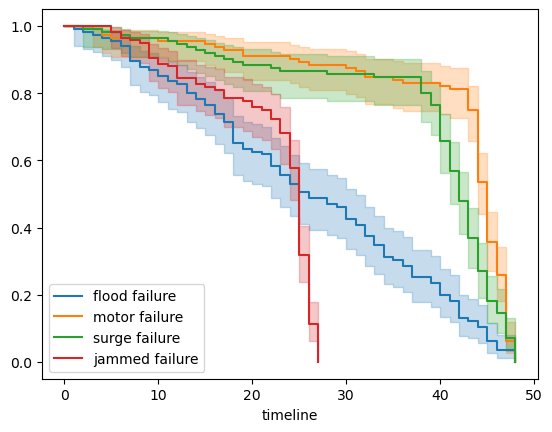

In [26]:
kmf = KaplanMeierFitter()
df_fail = df[df['reason'].isin([1, 2, 3, 4])]

reason_mapping = {
    1: 'flood failure',
    2: 'motor failure',
    3: 'surge failure',
    4: 'jammed failure'
}

# Apply the mapping to the 'reason' column
df_fail['reason'] = df_fail['reason'].map(reason_mapping)

for group in df_fail['reason'].unique():
    kmf.fit(df_fail[df_fail['reason'] == group]['hour'], label=group)
    kmf.plot()
plt.show()

## Conditional failure probabilities across time for pumps broken down by failure type overlaid into one graph

In [27]:
km_val = kmf.event_table
hazard = km_val.observed/km_val.at_risk
hazard

event_at
0.0     0.000000
5.0     0.017241
6.0     0.017544
7.0     0.008929
8.0     0.009009
9.0     0.045455
10.0    0.019048
11.0    0.009709
12.0    0.039216
14.0    0.020408
15.0    0.010417
16.0    0.010526
17.0    0.031915
19.0    0.010989
20.0    0.022222
21.0    0.011364
22.0    0.034483
23.0    0.059524
24.0    0.151899
25.0    0.447761
26.0    0.648649
27.0    1.000000
dtype: float64

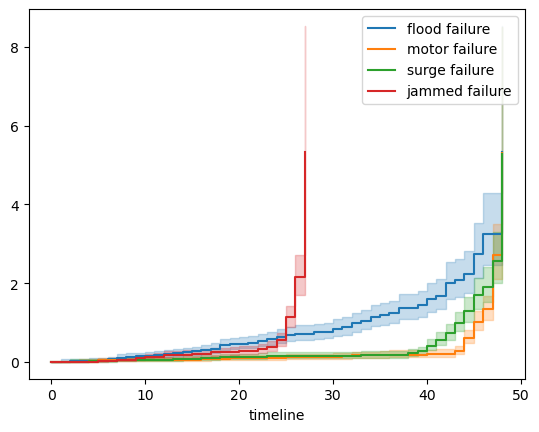

In [28]:
cum_haz=NelsonAalenFitter()
for group in df_fail['reason'].unique():
    cum_haz.fit(df_fail[df_fail['reason'] == group]['hour'], label=group)
    cum_haz.plot_cumulative_hazard()
plt.show()

## Statistical test to see if the major types of failure have similar survival probabilities across time 

In [29]:
#pairwise_logrank_test performs the logrank test pairwise for all unique groups
#result = pairwise_logrank_test(df_fail['hour'], df_fail['reason'])
result = multivariate_logrank_test(df_fail['hour'], df_fail['reason'])
result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         247.38 <0.005    174.79

https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html#lifelines.statistics.pairwise_logrank_test